# 2022-04-28 • Interpolate N = 30 .. 6000

The N = 30 case had a fixed firing rate for the input neurons (of 20 Hz).  
We'll now also give it the lognormal (with mean 4 Hz) firing rate distribution.

We must introduce a new concept / parameter: the desired **stimulation rate** of the input neurons.
It is a product of average firing rate and 'stimulation' (synaptic conductance increase, Δg) per spike.
Given that average spike rate is fixed (namely 4 Hz), we use this paramter to calculate Δg.

A sensible value for it is taken from the previous (N = 6600) notebook
where Δg_exc was 0.4 nS and the Δg_multiplier was 0.066.

We'll thus choose `avg_stimulation_rate__exc` to be 0.4 nS * 0.066 * 4 Hz, or **0.1 nS/second**.
Our inhibitory inputs have 4x the strength, so `avg_stimulation_rate__inh` will be **0.4 nS/second**.

The actual stimulation rate for each input neuron will vary from these, as their firing rates are not 4 Hz, but rather distributed lognormally somewhere around that.

## Setup

In [1]:
#

In [2]:
using Revise

In [3]:
using MyToolbox

In [ ]:
using VoltageToMap

## Params & sim

Short warm-up run. Get compilation out of the way.

In [13]:
warmup_params = SimParams(
        input = previous_N_30_input,
        duration = 1 * minutes
);

In [14]:
@time sim(warmup_params);

  0.548508 seconds (1.21 M allocations: 183.612 MiB, 71.45% gc time)


In [9]:
p = ExperimentParams(
    sim = SimParams(
        input = realistic_N_6600_input,
        duration = 0.2 * minutes,
    )
);
dumps(p)

ExperimentParams
  rngseed: 22022022
  sim: SimParams
    duration: 12.0
    Δt: 0.0001
    num_timesteps: 120000
    rngseed: 0
    input: PoissonInputParams
      N_unconn: 100
      N_exc: 5200
      N_inh: 1300
      N_conn: 6500
      N: 6600
      spike_rates: LogNormal
        μ: 1.08629
        σ: 0.774597
    synapses: SynapseParams
      Δg_exc: 4.0e-10
      Δg_inh: 1.6e-9
      Δg_multiplier: 0.066
      E_exc: 0.0
      E_inh: -0.065
      g_t0: 0.0
      τ: 0.007
    izh_neuron: IzhikevichParams
      C: 1.0e-10
      k: 7.0e-7
      v_rest: -0.06
      v_thr: -0.04
      a: 30.0
      b: -2.0e-9
      v_peak: 0.035
      v_reset: -0.05
      Δu: 1.0e-10
      v_t0: -0.06
      u_t0: 0.0
    imaging: VoltageImagingParams
      spike_SNR: 10.0
      spike_SNR_dB: 20.0
      spike_height: 0.095
      σ_noise: 0.0095
  conntest: ConnTestParams
    STA_window_length: 0.1
    num_shuffles: 100
    rngseed: 22022022
  evaluation: EvaluationParams
    num_tested_neurons_per_grou

In [8]:
t, v, vimsig, input_spikes = @time sim(p.sim);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
  4.708045 seconds (4.80 M allocations: 372.494 MiB, 2.00% gc time, 39.88% compilation time)


In [9]:
num_spikes = length.(input_spikes)

ComponentVector{Int64}(conn = (exc = [24, 18, 27, 22, 12, 23, 20, 6, 18, 18  …  20, 18, 26, 22, 7, 12, 26, 8, 22, 15], inh = [7, 19, 16, 1, 19, 13, 21, 22, 3, 14  …  27, 15, 21, 7, 22, 26, 20, 17, 18, 27]), unconn = [22, 18, 15, 22, 29, 17, 12, 29, 14, 14  …  29, 16, 20, 4, 28, 27, 28, 11, 10, 8])

## Plot

In [10]:
import PyPlot

In [11]:
using VoltageToMap.Plot

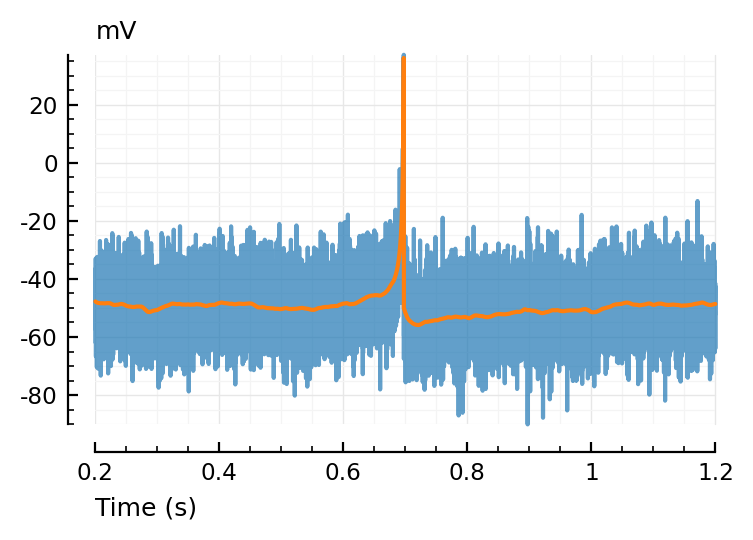

In [12]:
tzoom = [200, 1200]ms
ax = plotsig(t, vimsig / mV, tzoom; xlabel="Time (s)", hylabel="mV", alpha=0.7);
plotsig(t, v / mV, tzoom; ax);

## Test conntest

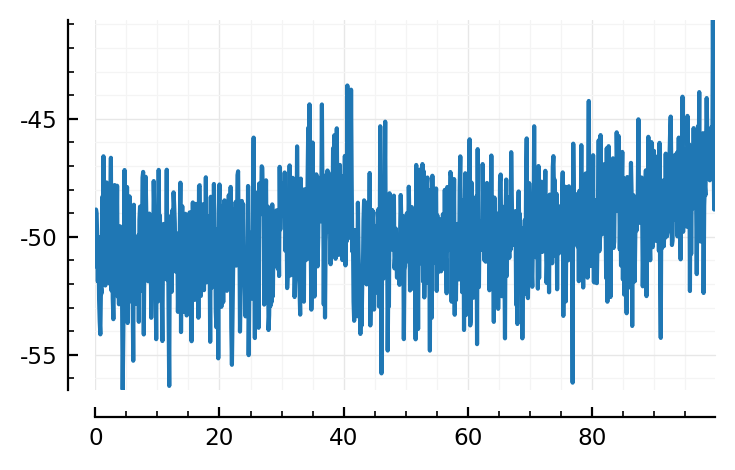

In [15]:
example_presynspikes = input_spikes.conn.exc[44]
plotSTA(vimsig, example_presynspikes, p);

In [19]:
p_value = test_connection(vimsig, example_presynspikes, p)

0.61

## Conntest performance

In [34]:
N_eval_trains = p.evaluation.num_tested_neurons_per_group

40

In [35]:
α = 0.05;

In [102]:
function evaluate_conntest_performance(vimsig, input_spikes, p)
    
    resetrng!(p.evaluation.rngseed)

    TP_exc = 0
    TP_inh = 0
    TP_unconn = 0

    for input_train in input_spikes.conn.exc[1:N_eval_trains]
        p_value = test_connection(vimsig, input_train, p)
        if p_value < α
            TP_exc += 1
        end
    end

    for input_train in input_spikes.conn.inh[1:N_eval_trains]
        p_value = test_connection(vimsig, input_train, p)
        if p_value > 1 - α
            TP_inh += 1
        end
    end

    for input_train in input_spikes.unconn[1:N_eval_trains]
        p_value = test_connection(vimsig, input_train, p)
        if α/2 ≤ p_value ≤ 1 - α/2
            TP_unconn += 1
        end
    end

    TPR_exc    = TP_exc / N_eval
    TPR_inh    = TP_inh / N_eval
    TPR_unconn = TP_unconn / N_eval
    
    FPR = 1 - TPR_unconn
    
    return TPR_exc, TPR_inh, FPR
end;

In [103]:
evaluate_conntest_performance(vimsig, input_spikes, p)

(0.05, 0.025, 0.025000000000000022)

## Performance for given params

In [104]:
function performance_for(p::ExperimentParams)
    _t, _v, vimsig, input_spikes = sim(p.sim);
    return evaluate_conntest_performance(vimsig, input_spikes, p)
end;

In [105]:
VI_params = VoltageImagingParams(;
    spike_height = cortical_RS.v_peak - cortical_RS.v_rest,
    spike_SNR = Inf,
);

In [154]:
durations = [
    30 * seconds,
    1 * minutes,
    5 * minutes,
    10 * minutes,
    20 * minutes,
    30 * minutes,
]
xlabels = durations / minutes .|> x -> @sprintf "%.3G" x;

In [150]:
TPRs_exc = Vector{Float64}()
TPRs_inh = Vector{Float64}()
FPRs     = Vector{Float64}()

for duration in durations
    @show duration / minutes
    params = ExperimentParams(sim = SimParams(; duration, imaging = VI_params))
    TPR_exc, TPR_inh, FPR = performance_for(params)
    @show TPR_exc, TPR_inh, FPR
    push!(TPRs_exc, TPR_exc)
    push!(TPRs_inh, TPR_inh)
    push!(FPRs, FPR)
    println()
end

duration / minutes = 0.5
Progress: 100%|█████████████████████████████████████████| Time: 0:00:06
(TPR_exc, TPR_inh, FPR) = (0.025, 0.025, 0.0)

duration / minutes = 1.0
Progress: 100%|█████████████████████████████████████████| Time: 0:00:15
(TPR_exc, TPR_inh, FPR) = (0.075, 0.075, 0.025000000000000022)

duration / minutes = 5.0
Progress: 100%|█████████████████████████████████████████| Time: 0:01:26
(TPR_exc, TPR_inh, FPR) = (0.05, 0.2, 0.050000000000000044)

duration / minutes = 10.0
Progress: 100%|█████████████████████████████████████████| Time: 0:02:30
(TPR_exc, TPR_inh, FPR) = (0.025, 0.225, 0.025000000000000022)

duration / minutes = 20.0
Progress: 100%|█████████████████████████████████████████| Time: 0:05:24
(TPR_exc, TPR_inh, FPR) = (0.125, 0.475, 0.050000000000000044)

duration / minutes = 30.0
Progress: 100%|█████████████████████████████████████████| Time: 0:07:40
(TPR_exc, TPR_inh, FPR) = (0.1, 0.55, 0.050000000000000044)



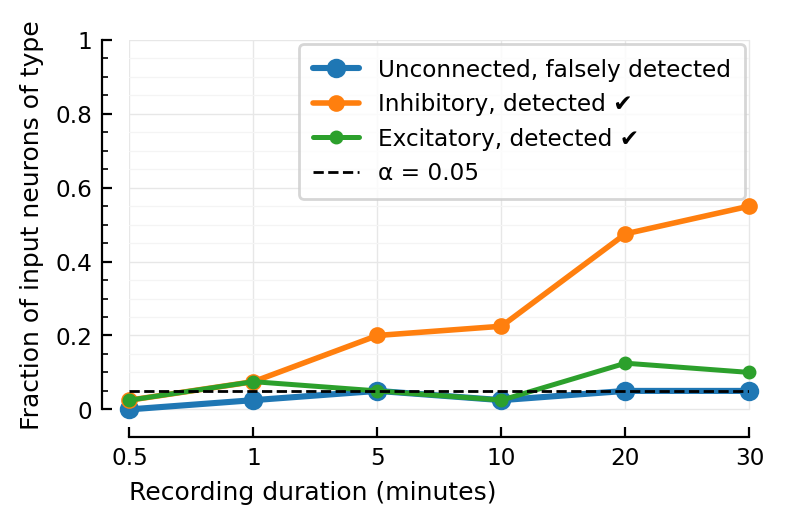

In [169]:
xticks = [1:length(durations);]
plott(rates; kw...) = plot(
    xticks, rates, ".-"; ylim=(0,1),
    xminorticks=false, clip_on=false, kw...
)
smaller = (lw=1.8, ms=08)
medium  = (lw=2.0, ms=10)
larger  = (lw=2.2, ms=12) 
ax = plott(FPRs;      larger...,  label="Unconnected, falsely detected")
ax = plott(TPRs_inh;  medium...,  label="Inhibitory, detected ✔")
ax = plott(TPRs_exc;  smaller..., label="Excitatory, detected ✔")
ax.set_xticks(xticks, xlabels)
ax.set_xlabel("Recording duration (minutes)")
ax.set_ylabel("Fraction of input neurons of type")
ax.axhline(α, color="black", zorder=3, lw=1, linestyle="dashed", label=f"α = {α:.3G}")
ax.legend();